(sec:ci)=
# Configuration interaction
## General theory

One of the conceptually (but not computationally) simplest way to solve the Schrödinger equation is to simply expand our many-body wave function on a $N$-electron basis set (not to be confused with the one-electron basis functions used to expand orbitals)

$$
| \Psi_{\text{CI}} \rangle = \sum_k c_k | \mathbf{k} \rangle 
$$

with energy

(eq:CIene)=
$$
E_{\text{CI}} = \frac{\langle \Psi_{\text{CI}} | \hat{H} | \Psi_{\text{CI}} \rangle}{\langle \Psi_{\text{CI}} | \Psi_{\text{CI}} \rangle} 
$$

We will discuss in the next section the choice of the basis, but in all cases, as the size of this basis set increases, the solution converges to the exact solution of the Schrödinger equation.

There is a redundancy in the parameters $c_k$, as multiplying them all by a constant does not change the energy. We thus add the constraint that the wave function should be normalized

$$
\langle \Psi_{\text{CI}} | \Psi_{\text{CI}} \rangle = \sum_k c_k^2 = 1
$$

To minimize the wave function subject to this constraint, we write a Lagrangian

$$
L = E - \epsilon(\sum_k c_k^2 -1)
$$

To define our minimization we set the gradient of our Lagrangian to 0 and obtain

$$
\frac{\mathrm{d}L}{\mathrm{d} c_k} =  \sum_i \langle \mathbf{i} | \hat{H} | \mathbf{k} \rangle c_i - \epsilon c_k + \text{c.c.}= 0 \, 
$$

where "$\text{c.c.}$" denotes the complex conjugate of the previous expression. This can finally be recast in the familiar form

$$
\mathbf{H} \mathbf{c} = \epsilon \mathbf{c}
$$

showing that minimizing the CI energy energy is equivalent to diagonalizing the Hamiltonian matrix in our chosen basis, with the eigenvalues being the energies of all possible states in the system. The ground state simply corresponds to the lowest eigenvalue.

## The $N$-electron basis

There are in principle an infinite number of possible $N$-electron basis to choose from, but we ideally want the expansion to converge quickly (compact expansion) and the functions to be easily manipulable to efficiently compute the Hamiltonian elements. Unfortunately, these two criteria often oppose each other.

As electron correlation depends on the distance between electrons, it would be natural to use functions that depend explicitly on this distance, the same way as our Gaussian or Slater one-electron basis depends explicitly on the distance between electron and nuclei. Wave functions having these properties are typically called explicitly correlated wave functions, but this interelectronic distance makes the calculation of integrals very difficult as it couples multiple electrons together.

We often drop this explicit dependence and instead use a wave function that is formed from products of one-electron functions, *i.e.*, a product of orbitals. The simplest of these basis functions is the [Hartree product](https://en.wikipedia.org/wiki/Hartree_equation), but since we know the wave function should be antisymmetric with respect to the exchange of two electrons, we instead use the antisymmetrised version of the Hartree product: [Slater determinants (SDs)](sec:slater). As each SD represents a different electronic configuration, the resulting method is called configuration interaction (CI). As discussed in the previous sections, this basis of SDs constitutes a complete basis within a specified one-electron basis set, and thus the solution obtained by minimizing the energy of this wave function is the exact ground state within that one-electron basis.

In some codes, [configuration state functions (CSFs)](https://en.wikipedia.org/wiki/Configuration_state_function) are used instead of SDs. CSFs are fixed linear combinations of SDs but with the attractive properties that they are also eigenfunctions of the $\hat{S}^2$ spin operator. This spin constraints means that the resulting wave function will always be spin-adapted and also that CSFs are less numerous than Slater determinants, which has advantages on a computational standpoint. However, SDs can be expressed as ordered "strings" of $\alpha$ and $\beta$ creating operators, and this separation of $\alpha$ and $\beta$ electrons allows for efficient computer implementations, outweighing the benefits of the slightly smaller expansion of CSF.

Having chosen SDs as our basis functions, we now need an efficient way to create our expansion, *i.e.*, a direct link between a given index in our expansion and the corresponding occupation of the SDs. This link should work both ways, matching a given occupation to the corresponding index in the expansion. A common choice is the so-called lexical ordering or the reverse lexical ordering. The details are beyond the scope of this page, but fortunately, the MultiPsi package provides the tools to do this.

Let's start by initializing a calculation for O$_2$. We will first run a Hartree--Fock (HF) calculation to generate starting orbitals. The ground state of this molecule is a triplet, so we will use unrestricted HF. Note that full CI is exact and does not depend on the actual shape of the orbitals, so we could have run a singlet calculation instead without changing the result.

In [1]:
import veloxchem as vlx
import multipsi as mtp
import numpy as np

O2_xyz = """2
O2                                                                                                                         
O    0.000000000000        0.000000000000       -0.600000000000 
O    0.000000000000        0.000000000000        0.600000000000 
"""

molecule = vlx.Molecule.from_xyz_string(O2_xyz)
molecule.set_multiplicity(3)
basis = vlx.MolecularBasis.read(molecule,"STO-3G")

scf_drv = vlx.ScfUnrestrictedDriver()
scf_results = scf_drv.compute(molecule, basis)

* Warning * Environment variable OMP_NUM_THREADS not set.
* Warning * Setting OMP_NUM_THREADS to 8.
* Info * Reading basis set from file: /opt/anaconda3/envs/echem/lib/python3.11/site-packages/veloxchem/basis/STO-3G       
                                                                                                                          
                                              Molecular Basis (Atomic Basis)                                              
                                                                                                                          
                               Basis: STO-3G                                                                              
                                                                                                                          
                               Atom Contracted GTOs           Primitive GTOs                                              
                                       

In [2]:
import py3Dmol as p3d
viewer = p3d.view(width=300, height=200)
viewer.addModel(O2_xyz, 'xyz')
viewer.setViewStyle({"style": "outline", "width": 0.05})
viewer.setStyle({"stick":{},"sphere": {"scale":0.25}})
viewer.rotate(90,'y')
viewer.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

The next step is to define our CI using the `MultiPsi.OrbSpace` object. The meaning of this step will become more clear when we discuss truncated CI and active spaces. Now we simply define a full CI by using the FCI keyword. Then we use the `CIExpansion` class to create the tools necessary to handle the CI expansion.

In [3]:
space = mtp.OrbSpace(molecule,scf_drv.mol_orbs)
space.fci()
expansion = mtp.CIExpansion(space)
print(expansion)


          CI expansion:
          -------------
Number of determinants:      1200




Printing the expansion shows the number of Slater determinants. As you can see, the number is already fairly large. This is not an issue in a real calculation, but for testing purposes, we will restrict this number a bit. For this, we will simply exclude the 1s and 2s of the oxygen from the calculation, which corresponds to "freezing" 4 orbitals.

In [4]:
space.fci(n_frozen=4)
expansion = mtp.CIExpansion(space)
print(expansion)


          CI expansion:
          -------------
Number of determinants:      120




Now we can look at the determinants themselves. The easiest way is to use the generator `detlist()` of the expansion class in a Python for loop, which as the name implies will provide the determinants in a predefined order, here in reverse lexical ordering.

By printing the determinant directly, we get the string representation, with a character for each orbital in the system. '2' indicates that the orbital is doubly occupied, 'a' and 'b' indicates an $\alpha$ or $\beta$ electron, and '0' an empty orbital. The determinant also provides a Python list of the orbitals containing a $\alpha$ or $\beta$ electron.

In [5]:
for det in expansion.determinant_list():
    print(det,det.occ_alpha(),det.occ_beta())

222aa0 [0, 1, 2, 3, 4] [0, 1, 2]
22a2a0 [0, 1, 2, 3, 4] [0, 1, 3]
2a22a0 [0, 1, 2, 3, 4] [0, 2, 3]
a222a0 [0, 1, 2, 3, 4] [1, 2, 3]
22aa20 [0, 1, 2, 3, 4] [0, 1, 4]
2a2a20 [0, 1, 2, 3, 4] [0, 2, 4]
a22a20 [0, 1, 2, 3, 4] [1, 2, 4]
2aa220 [0, 1, 2, 3, 4] [0, 3, 4]
a2a220 [0, 1, 2, 3, 4] [1, 3, 4]
aa2220 [0, 1, 2, 3, 4] [2, 3, 4]
22aaab [0, 1, 2, 3, 4] [0, 1, 5]
2a2aab [0, 1, 2, 3, 4] [0, 2, 5]
a22aab [0, 1, 2, 3, 4] [1, 2, 5]
2aa2ab [0, 1, 2, 3, 4] [0, 3, 5]
a2a2ab [0, 1, 2, 3, 4] [1, 3, 5]
aa22ab [0, 1, 2, 3, 4] [2, 3, 5]
2aaa2b [0, 1, 2, 3, 4] [0, 4, 5]
a2aa2b [0, 1, 2, 3, 4] [1, 4, 5]
aa2a2b [0, 1, 2, 3, 4] [2, 4, 5]
aaa22b [0, 1, 2, 3, 4] [3, 4, 5]
222a0a [0, 1, 2, 3, 5] [0, 1, 2]
22a20a [0, 1, 2, 3, 5] [0, 1, 3]
2a220a [0, 1, 2, 3, 5] [0, 2, 3]
a2220a [0, 1, 2, 3, 5] [1, 2, 3]
22aaba [0, 1, 2, 3, 5] [0, 1, 4]
2a2aba [0, 1, 2, 3, 5] [0, 2, 4]
a22aba [0, 1, 2, 3, 5] [1, 2, 4]
2aa2ba [0, 1, 2, 3, 5] [0, 3, 4]
a2a2ba [0, 1, 2, 3, 5] [1, 3, 4]
aa22ba [0, 1, 2, 3, 5] [2, 3, 4]
22aa02 [0,

## The CI Hamiltonian

Now that we have the list of determinants, we only need to form the CI Hamiltonian. For this, we need to be able to calculate the matrix elements.

MultiPsi also provides a function to do that. For this, we initialize the `CIOperator` class and set it to the Hamiltonian operator. This class then compute the integrals in the molecular basis and provides several functions to use them in a CI calculation.

In [6]:
CIham=mtp.CIOperator(expansion)
CIham.compute_Hints(molecule,basis) #Set the operator to be the molecular Hamiltonian

We can now construct the Hamiltonian. The easiest is to simply do a double loop over SD and compute the matrix element using the `Hij` function of `CIOperator`:

In [7]:
Ham = np.zeros((expansion.n_determinants,expansion.n_determinants))
for i,idet in enumerate(expansion.determinant_list()):
    for j,jdet in enumerate(expansion.determinant_list()):
        Ham[i,j]=CIham.Hij(idet,jdet)

If we diagonalize this Hamiltonian, we obtain all the energies of the system, both ground and excited states:

In [8]:
w,v = np.linalg.eigh(Ham)
print(w)

[-147.72339194 -147.49488796 -147.49488796 -147.48991742 -147.39178263
 -147.39178263 -147.31022148 -147.27297821 -147.27297821 -147.14365547
 -147.14365547 -147.08916312 -147.08916312 -147.08242927 -147.07852818
 -147.05836503 -147.05836503 -147.00699461 -147.00699461 -146.99905665
 -146.99905665 -146.97927131 -146.97927131 -146.95353201 -146.9354175
 -146.93382892 -146.93382892 -146.88967934 -146.88967934 -146.88480791
 -146.83509186 -146.83509186 -146.82598782 -146.75346539 -146.75346539
 -146.75077715 -146.75077715 -146.74829521 -146.74125314 -146.74125314
 -146.71397134 -146.71397134 -146.70255217 -146.70255217 -146.64273756
 -146.6366741  -146.6366741  -146.56810118 -146.53923066 -146.48989258
 -146.48989258 -146.48113701 -146.48113701 -146.47615159 -146.43900556
 -146.43900556 -146.43155944 -146.41314138 -146.40393925 -146.37524854
 -146.37524854 -146.34672641 -146.33446114 -146.33446114 -146.27975068
 -146.2749686  -146.2749686  -146.26378644 -146.22065448 -146.21747518
 -146.2

Note how the first (and lowest) energy is indeed lower than the one found at the Hartree--Fock level, due to electron correlation. However, it is important to note that some of the states obtained here are not actually triplet but have a higher multiplicity.

As we discussed in the previous section, the basis of SDs is not spin-adapted. The only constraint in our expansion is the value of $m_s$, here $m_s = 1$, meaning we have two more $\alpha$ electrons than $\beta$. This excludes singlet (which can only have $m_s=0$) but does not exclude some quintets or higher.

We can also print the first eigenvector:

In [9]:
np.set_printoptions(formatter={'float_kind':"{:.3f}".format})
print(v[:,0])

[0.969 -0.000 -0.000 -0.000 0.000 -0.000 0.000 0.000 0.000 0.176 0.000
 0.000 -0.000 -0.001 -0.073 0.000 -0.073 0.001 0.000 0.000 0.000 0.000
 -0.000 0.000 0.000 0.000 0.000 -0.000 -0.004 0.000 -0.000 0.000 -0.000
 -0.000 -0.000 -0.000 -0.000 0.000 0.000 -0.000 0.000 -0.000 -0.000 0.000
 -0.000 0.000 -0.000 -0.004 0.000 0.000 -0.000 -0.000 -0.000 0.000 -0.000
 0.000 -0.000 0.000 -0.000 -0.000 0.000 -0.000 0.001 0.078 0.000 0.078
 -0.001 0.000 -0.000 0.000 -0.066 0.000 -0.000 -0.000 -0.000 -0.000 -0.000
 0.000 -0.000 -0.036 -0.000 0.000 -0.000 -0.000 0.009 -0.000 0.000 0.000
 0.000 -0.000 0.000 -0.019 0.000 0.000 -0.000 -0.000 -0.000 0.000 0.000
 0.000 0.000 0.009 -0.000 0.000 -0.000 0.000 -0.000 -0.000 0.000 0.000
 -0.000 0.000 -0.019 0.000 0.000 0.000 -0.000 -0.000 0.000 -0.000]


One can see that the largest coefficient is the first one, corresponding to the '222aa0' determinant, which indeed is the expected ground state configuration.

You may be curious as to what happens in the `Hij` function, that is, how we compute the $\langle i | H | j \rangle $ matrix elements. The answer to this is the Slater--Condon rules, see the section on [Slater Determinants](sec:slater). This rules define the matrix elements in terms of molecular integrals, depending on the difference in occupation between the two determinants. The difference in occupation is easily formulated in terms of excitations, with different rules depending on if $|j \rangle$ is singly or doubly excited compared to $|i \rangle$. Any higher excitation will simply lead to 0.

These rules are relatively easy to derive, both in standard and second quantization formulation. The idea is that the Hamiltonian has to "reconcile" the excitations. Being a two-electron operator, the Hamiltonian can reconcile at most two excitations.

First we need to obtain the necessary integrals. Those are the standard one- and two-electron integrals but in the MO basis, as the expressions are simpler in this basis. Since we are leaving some occupied orbitals outside of the CI space (the s orbitals), also called inactive orbitals, we also need to include their interaction with the electrons in our CI. This is done by replacing the one-electron integrals by the inactive Fock matrix defined as

$$
F^I_{pq} = h_{pq} + \sum_{i \in \mathrm{inactive}} 2 (pq|ii) - (pi|qi) 
$$

As in Hartree--Fock, we efficiently compute this matrix in the AO basis

$$
F^I_{\mu\nu} = h_{\mu\nu} + \sum_{\lambda\sigma} 2 D^I_{\lambda\sigma}(\mu\nu|\lambda\sigma) - (\mu \lambda|\nu\sigma) 
$$
using the inactive density matrix defined from the MO coefficients $C^i_\mu$

$$
D^I_{\mu\nu}= \sum_{i \in \mathrm{inactive}} C^i_\mu C^i_\nu
$$

To compute the total energy, we also need to include the inactive energy, which is simply the energy of the inactive electrons and the nuclear-nuclear repulsion term.

$$
E^I = V_{NN} + \sum_{i \in \mathrm{inactive}} 2 ( h_{ii} + F^I_{ii} )
$$

or using the AO matrices

$$
E^I = V_{NN} + \sum_{pq} D^I_{\mu\nu} ( h_{\mu\nu} + F^I_{\mu\nu} )
$$


In [10]:
nIn = space.n_inactive # number of inactive orbitals
nAct = space.n_active # number of active orbitals
nbas = space.n_orbitals # total number of orbitals

############################
## Get integrals and V_NN ##
############################
V_nuc = molecule.nuclear_repulsion_energy()

# one-electron Hamiltonian
kinetic_drv = vlx.KineticEnergyIntegralsDriver()
T = kinetic_drv.compute(molecule, basis).to_numpy()

nucpot_drv = vlx.NuclearPotentialIntegralsDriver()
V = -nucpot_drv.compute(molecule, basis).to_numpy()

h = T + V 

# two-electron Hamiltonian
eri_drv = vlx.ElectronRepulsionIntegralsDriver()
g = eri_drv.compute_in_memory(molecule, basis)

#################################
## Compute the needed matrices ##
#################################
C = scf_drv.mol_orbs.alpha_to_numpy()
Cact=C[:, nIn:nIn+nAct] # active MOs

As an exercise, the reader is invited to compute the inactive energy and Fock matrix:

```python
# Compute the inactive density matrix
Din = ...

# Compute the inactive Fock matrix in AO
Jin = ... # Coulomb term
Kin = ... # Exchange term
Fin = ... # Fock matrix

#Compute the inactive energy:
Ein = ...
```

In [11]:
# Compute the inactive density matrix
Din = np.einsum('mi,ni->mn', C[:, :nIn], C[:, :nIn])

# Compute the inactive Fock matrix in AO
Jin = np.einsum('mnls,ls->mn', g, Din) # Coulomb term
Kin = np.einsum('mlns,ls->mn', g, Din) # Exchange term
Fin = h + 2*Jin - Kin # Fock matrix

#Compute the inactive energy:
Ein = np.einsum('ij,ij->', h + Fin, Din) + V_nuc

In [12]:
# Transform the Fock matrix to active MO basis
Ftu = np.einsum("pq,qu, pt->tu", Fin, Cact, Cact)

#Transform the 2-electron integrals to active MO basis
pqrw = np.einsum("pqrs,sw->pqrw", g   , Cact)
pqvw = np.einsum("pqrw,rv->pqvw", pqrw, Cact)
puvw = np.einsum("pqvw,qu->puvw", pqvw, Cact)
tuvw = np.einsum("puvw,pt->tuvw", puvw, Cact)

We can compare our results to those provided directly by `CIham` if needed:

In [13]:
assert abs(Ein - CIham.inEne)<1.0e-8
np.testing.assert_almost_equal(Ftu, CIham.Ftu)
np.testing.assert_almost_equal(tuvw, CIham.tuvw)

Using those integrals, we can now implement the Slater--Condon rules:

In [14]:
def SC_diag(occa, occb):
    '''
    The energy of a given SD, as a function of its list of occupied orbitals
    '''
    Hij = Ein #Inactive energy (inc. nuclear repulsion)
    
    for i in occa:
        Hij += Ftu[i,i] #1-e term = inactive Fock matrix
        for j in occa:
            if i < j:
                Hij += tuvw[i,i,j,j] - tuvw[i,j,j,i] #Coulomb-Exchange
        for j in occb:
            Hij += tuvw[i,i,j,j]
            
    for i in occb:
        Hij += Ftu[i,i]
        for j in occb:
            if i < j:
                Hij += tuvw[i,i,j,j]-tuvw[i,j,j,i]
    return Hij

def SC_1exc(i, a, ss_occ, os_occ):
    '''
    Slater-Condon between a SD and a singly excited determinant,
    depending on the excited orbitals (i,a) and the same-spin
    (compared to spin of the excited electron) and opposite-spin occupation
    '''
    Hij = Ftu[i,a]
    
    for k in ss_occ:
        Hij += tuvw[i,a,k,k] - tuvw[i,k,k,a]
    for k in os_occ:
        Hij += tuvw[i,a,k,k]
        
    return Hij

def SC_ss1exc(i,a,j,b):
    '''
    Slater-Condon between a SD and a doubly excited determinant,
    with both excited electrons having the same spin
    '''
    return tuvw[i,a,j,b] - tuvw[i,b,j,a]

def SC_os1exc(i,a,j,b):
    '''
    Slater-Condon between a SD and a doubly excited determinant,
    with the excited electrons having opposite spin
    '''
    return tuvw[i,a,j,b]

The difficult part is to make sure that the occupations of the Slater determinants are brought to maximum concordance. The expansion produced by lexical ordering may not have this property, but one can switch electrons until we reach this maximum concordance, introducing a negative phase factor at each electron exchange.

Again, MultiPsi provides a convenient way to achieve this. The idea is to explicitly create the singly excited determinant (or doubly excited by applying the operation twice) and then keep track of the number of exchanges to bring it to natural ordering. The `excite_alpha` and `excite_beta` functions do this, providing both the excited determinant and the phase factor. The `index()` function of the determinants then provides the index of the given determinant in the expansion, in order to associate the energy to the correct position in the Hamiltonian.

With these new tools and our Slater--Condon functions, we can now rewrite the above code. We replace the double loop by a simple loop and then an explicit construction of all singly and doubly excited determinants. The resulting code looks more complex but is relatively easy to follow.

In [15]:
Ham = np.zeros((expansion.n_determinants,expansion.n_determinants))

for idet, det in enumerate(expansion.determinant_list()):
    
    #Diagonal term
    Ham[idet,idet] = SC_diag(det.occ_alpha(),det.occ_beta())
    
    #Single excitations alpha
    for i in det.occ_alpha():
        for a in det.unocc_alpha():
            phase, excdet = det.excite_alpha(i,a)
            Ham[idet, excdet.index()] = phase * SC_1exc(i,a,det.occ_alpha(),det.occ_beta())
            
            #alpha-alpha excitation
            for j in det.occ_alpha():
                if i >= j:
                    continue
                for b in det.unocc_alpha():
                    if a >= b:
                        continue
                    phase2, exc2det = excdet.excite_alpha(j,b)
                    Ham[idet, exc2det.index()] = phase * phase2 * SC_ss1exc(i,a,j,b)
                    
            #alpha-beta excitation
            for j in det.occ_beta():
                for b in det.unocc_beta():
                    phase2, exc2det = excdet.excite_beta(j,b)
                    Ham[idet, exc2det.index()] = phase * phase2 * SC_os1exc(i,a,j,b)
                    
    #Single excitations beta
    for i in det.occ_beta():
        for a in det.unocc_beta():
            phase, excdet = det.excite_beta(i,a)
            Ham[idet, excdet.index()] = phase * SC_1exc(i,a,det.occ_beta(), det.occ_alpha())
            
            #beta-beta excitation
            for j in det.occ_beta():
                if i >= j:
                    continue
                for b in det.unocc_beta():
                    if a >= b:
                        continue
                    phase2, exc2det = excdet.excite_beta(j,b)
                    Ham[idet, exc2det.index()] = phase * phase2 * SC_ss1exc(i,a,j,b) 

The advantage of this loop structure is that we only compute the non-zero elements. It can be easily verified that we obtain the same result:

In [16]:
w,v = np.linalg.eigh(Ham)
print(w[0:3])

[-147.723 -147.495 -147.495]


## Direct CI

As we saw, the number of SDs ($N_{\mathrm{SD}}$) grows extremely rapidly with the size of the system. The Hamiltonian matrix grows even faster, with size $N_{\mathrm{SD}}^2$. For example, for a singlet with 6 electron in 6 orbitals, the number of SD is 210, growing to 31,878 for 10 electrons in 10 orbitals and 82,824,885 for 16 in 16. At this scale, storing the Hamiltonian matrix would take nearly 7,000 TB. Most of the matrix elements are zero, but even using sparse storage, the memory footprint is enormous.

Fortunately, we are rarely if ever interested in the entire list of excited states, instead usually focusing on the ground state and/or a couple of excited states. In this case, one can replace the diagonalization of the Hamiltonian by an iterative process where we progressively optimize a couple of states. In this case, we do not need to store the entire Hamiltonian matrix, but we only need to know its effect on a vector, the so-called $\boldsymbol{\sigma}$ vector

$$
\boldsymbol{\sigma} = \mathbf{H} \mathbf{c}
$$

In order to solve $ \mathbf{H} \mathbf{c} = \epsilon \mathbf{c} $, we can use a method similar to [conjugate gradient](https://en.wikipedia.org/wiki/Conjugate_gradient_method) optimization, which in this context is called the Davidson method. At each iteration, a new trial vector is constructed according to

(eq:cidav)=
$$
\mathbf{c_{\mathrm{dav}}} = (\mathbf{H_0} - \epsilon)^{-1} \mathbf{r}
$$

With $\mathbf{H_0}$ being a preconditioner, typically the diagonal of the Hamiltonian, and $\mathbf{r}$ the residual vector

$$
\mathbf{r} = (\mathbf{H} - \epsilon) \mathbf{c} = \boldsymbol{\sigma} - \epsilon \mathbf{c}
$$

To compute the improved CI vector, one may create and diagonalize a small Hamiltonian matrix in the basis of $\mathbf{c}$ and $\mathbf{c_{\mathrm{dav}}}$, sometimes including also the vectors at previous iterations to improve convergence.

Thus, only quantities with sizes equal to the number of SD are needed, and expansions up to hundreds of millions of determinants can be computed on a standard computer.

The code we had to compute the Hamiltonian can be trivially modified to compute the sigma vector. One simply need to change:

```python
Ham[i,j] = X
```
to

```
sigma[i] = X * vector[j]
```

We leave this as an exercise for the reader:

```python
def sigma(vector):
    result = np.zeros(expansion.n_determinants)
    
    for idet, det in enumerate(expansion.determinant_list()):
        ...

    return result

```

In [17]:
def sigma(vector):
    result = np.zeros(expansion.n_determinants)
    
    for idet, det in enumerate(expansion.determinant_list()):
        #Diagonal term
        result[idet] += SC_diag(det.occ_alpha(), det.occ_beta()) * vector[idet]
        
        #Single excitations alpha
        for i in det.occ_alpha():
            for a in det.unocc_alpha():
                phase, excdet = det.excite_alpha(i,a)
                result[excdet.index()] += phase * SC_1exc(i,a,det.occ_alpha(),det.occ_beta()) * vector[idet]
                
                #alpha-alpha excitation
                for j in det.occ_alpha():
                    if i >= j:
                        continue
                    for b in det.unocc_alpha():
                        if a >= b:
                            continue
                        phase2, exc2det = excdet.excite_alpha(j,b)
                        result[exc2det.index()] += phase * phase2 * SC_ss1exc(i,a,j,b) * vector[idet]
                        
                #alpha-beta excitation
                for j in det.occ_beta():
                    for b in det.unocc_beta():
                        phase2, exc2det = excdet.excite_beta(j,b)
                        result[exc2det.index()] += phase * phase2 * SC_os1exc(i,a,j,b) * vector[idet]
                        
        #Single excitations beta
        for i in det.occ_beta():
            for a in det.unocc_beta():
                phase,excdet = det.excite_beta(i,a)
                result[excdet.index()] += phase * SC_1exc(i,a,det.occ_beta(), det.occ_alpha()) * vector[idet]
                
                #beta-beta excitation
                for j in det.occ_beta():
                    if i >= j:
                        continue
                    for b in det.unocc_beta():
                        if a >= b:
                            continue
                        phase2, exc2det = excdet.excite_beta(j,b)
                        result[exc2det.index()] += phase * phase2 * SC_ss1exc(i,a,j,b) * vector[idet]
    return result

We can check that we get the same result as using the explicit Hamiltonian.

In [18]:
vec0 = np.random.rand(expansion.n_determinants) #Create a random vector

# Check that one gets the same result with
#  this new function as doing explicitely H.C
np.testing.assert_almost_equal(np.dot(Ham, vec0), sigma(vec0))

We have now all the tools needed to optimize our CI vector. We will first initialize the CI vector to the dominant Slater determinant (conveniently, the first one) and perform the Davidson steps until convergence.

In [19]:
#Compute Hdiag
Hdiag = np.empty(expansion.n_determinants)
for idet,det in enumerate(expansion.determinant_list()):
    Hdiag[idet] = SC_diag(det.occ_alpha(), det.occ_beta())
    
vec0 = np.zeros(expansion.n_determinants)
lowest_state = np.argmin(Hdiag)

vec0[lowest_state] = 1 # Initialise to the HF reference

resnorm = 1
istep = 0
while resnorm > 0.0001: # As long as the residual norm is large
    istep += 1
    
    sigvec0 = sigma(vec0)
    # Note that above technically does not need to be recomputed from scratch at each iteration
    energy = np.dot(vec0,sigvec0)
    print("Energy at step", istep, "=", energy)
    
    #Compute residual and its norm
    residual = sigvec0-energy*vec0
    resnorm = np.linalg.norm(residual)
    
    #Compute Davidson update
    preconditioner = 1/(Hdiag - energy + 0.0001) #0.0001 to prevent divergence
    vec1 = preconditioner * residual
    
    #Orthonormalize with vec0
    vec1 -= np.dot(vec1, vec0) * vec0
    norm = np.linalg.norm(vec1)
    vec1 *= 1/norm
    sigvec1 = sigma(vec1)
    
    #Create small hamiltonian
    smallHam = np.zeros((2,2))
    smallHam[0,0] = energy
    smallHam[0,1] = np.dot(vec0,sigvec1)
    smallHam[1,0] = np.dot(vec1,sigvec0)
    smallHam[1,1] = np.dot(vec1,sigvec1)
    
    #Form the updated CI vector using the eigenvector
    w,v = np.linalg.eigh(smallHam)
    vec0 = v[0,0] * vec0 + v[1,0] * vec1
    norm = np.linalg.norm(vec0)
    vec0 *= 1/norm    

Energy at step 1 = -147.6295384002184
Energy at step 2 = -147.71977361694397
Energy at step 3 = -147.7232275791889
Energy at step 4 = -147.7233757413098
Energy at step 5 = -147.72338994868556
Energy at step 6 = -147.72339158098222
Energy at step 7 = -147.7233918713915
Energy at step 8 = -147.723391924795
Energy at step 9 = -147.72339193510746


We can compare this to the CI optimization in MultiPsi:

In [20]:
CIdrv = mtp.CIDriver()
# By default, the guess is done by diagonalising a small segment of the full Hamiltonian
# here set the dimension of this Hamiltonian to 1, which corresponds to simply starting from a single SD
CIdrv.n_guess = 1
ci_results = CIdrv.compute(molecule, basis, space)

                          Configuration Interaction Driver
                                                                                                                          

          Active space definition:
          ------------------------
Number of inactive (occupied) orbitals: 4
Number of active orbitals:              6
Number of virtual orbitals:             0

    This is a CASSCF wavefunction: CAS(8,6)

          CI expansion:
          -------------
Number of determinants:      120


        ╭────────────────────────────────────╮
        │          Driver settings           │
        ╰────────────────────────────────────╯
          Max. iterations         : 40
          Initial diagonalization : 1
          Max subspace size       : 10
          Convergence thresholds:
            - Energy change       : 1e-08
            - Residual square norm: 1e-08
          Standard Davidson step
                                                                                    

The CI code is of course more efficient, being fully optimized, and converge in slightly fewer iterations than our test code. This is done despite a stricter convergence threshold, and is a result of by keeping old vectors when forming the small Hamiltonian (up to 10 by default).

## Density matrices and natural orbitals

In order to compute expectation values, which us useful for properties as well as an intermediate for some electronic structure methods (such as [MCSCF](sec:static-correlation)), we often need to compute density matrices.

The one-particle density matrix (in MO basis) is defined in second quantization as

$$
D_{pq} = \langle 0 | \hat{a}_p^\dagger \hat{a}_q | 0 \rangle
$$

It is easy to see that for a single SD, this simplifies to

$$
D^\mathrm{HF}_{pq} = \langle \mathrm{HF} | \hat{a}_p^\dagger \hat{a}_q | \mathrm{HF} \rangle = \delta_{pq}
$$

for $p$ and $q$ occupied, and 0 otherwise.

However, for CI wave functions, the resulting equation is more complex. In [exercises](sec:ci-exercises) we will try to implement this using a similar structure as the code for the $\sigma$ vector.

One of the uses of the one-particle density matrix is that it allows an intuitive look at the correlated wave function by looking at the occupation number of the so-called natural orbitals. Indeed, while orbitals are originally born out of a mean-field theory and are technically not appropriate representations of a real (*i.e.*, correlated) wave function, their intuitive power is undeniable.

[Natural orbitals](natural_orbitals) generalize the concept of orbitals to correlated wave functions. The occupation numbers are now non-integer between 2 and 0, representing a sort of weighted average of the occupations across all configurations. By doing so, the occupation number offer a measure of correlation --- occupations far from an integer value reflecting significant deviations from the mean-field picture, and thus significant correlation effects. Further discussion of these natural orbitals is included in the chapter on multiconfigurational methods.

In [21]:
Dpq = CIdrv.get_active_density(0) # Get the density for state 0

w, v = np.linalg.eigh(Dpq)
print("Natural occupation numbers for O2: ", np.flip(w))

Natural occupation numbers for O2:  [1.966 1.955 1.955 1.044 1.044 0.036]


Here we recognize the dominant configuration that we found earlier (222aa0), but with deviations coming from electron correlation. It is interesting to note how the occupation often work in pairs summing up approximately to an integer. This reflects that the dominant correlation (especially in this minimal basis case) is often within a bond itself, between the bonding and anti-bonding orbitals. In this example, the first and last orbitals correspond to the $\sigma$ and $\sigma^*$ with 2 electrons in total while orbitals 2 and 3 are $\pi$ and 4 and 5 are $\pi^*$ with 3 electrons in each orbital pairs.

(sec:truncated-ci)=
## Truncated CI
### Restricting the excitations

This full CI method is only useful conceptually or for very small molecules as a benchmark reference. The issue is  that the  number of determinants  grows very  fast (factorially) with the size of the system.  For example, a simple water molecule in a polarization double zeta basis, corresponding to 10 electrons and 24 orbitals, would require 903.316.260 determinants. While such a calculation is possible, it is very expensive, and it should be obvious from this example that full CI cannot be used on any real size system.

From here, different directions can be taken to turn CI into a useful computational tool. The first one is to restrict excitations, and thus the number of determinants involved  in  the  calculation. After all, a single  SD  turned  out to be  a reasonable approximation in most cases. As a the Hamiltonian is a two-electron operator, a determinant only interacts directly with at most doubly excited determinants, which suggests that those are those which would contribute the most to the energy. This can easily be tested on a small molecule like water. 

In [22]:
h2o_xyz = """3
water                                                                                                                          
O    0.000000000000        0.000000000000        0.000000000000                         
H    0.000000000000        0.740848095288        0.582094932012                         
H    0.000000000000       -0.740848095288        0.582094932012
"""

H2O = vlx.Molecule.from_xyz_string(h2o_xyz)
basis = vlx.MolecularBasis.read(H2O, "6-31G")

scf_drv = vlx.ScfRestrictedDriver()
scf_results = scf_drv.compute(H2O, basis)
H2O_orbs = scf_drv.mol_orbs
E_hf = scf_drv.get_scf_energy()

* Info * Reading basis set from file: /opt/anaconda3/envs/echem/lib/python3.11/site-packages/veloxchem/basis/6-31G        
                                                                                                                          
                                              Molecular Basis (Atomic Basis)                                              
                                                                                                                          
                               Basis: 6-31G                                                                               
                                                                                                                          
                               Atom Contracted GTOs           Primitive GTOs                                              
                                                                                                                          
                

In [23]:
import py3Dmol as p3d
viewer = p3d.view(width=300, height=200)
viewer.addModel(h2o_xyz, 'xyz')
viewer.setViewStyle({"style": "outline", "width": 0.05})
viewer.setStyle({"stick":{},"sphere": {"scale":0.25}})
viewer.rotate(90,'y')
viewer.rotate(-90,'x')
viewer.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [24]:
Energies = []

space = mtp.OrbSpace(H2O,H2O_orbs)
CIdrv = mtp.CIDriver()

for excitations in range(1,5):
    space.ci(excitations)    # Compute CIS, CISD, CISDT and CISDTQ
    ci_results = CIdrv.compute(H2O,basis,space)
    Energies.append(CIdrv.get_energy())

space.fci()   # Compute fullCI
ci_results = CIdrv.compute(H2O,basis,space)
E_FCI = CIdrv.get_energy()

                          Configuration Interaction Driver
                                                                                                                          

          Active space definition:
          ------------------------
Number of inactive (occupied) orbitals: 0
Number of active orbitals:              13
Number of virtual orbitals:             0

    This is a GASSCF wavefunction

         Cumulated   Min cumulated    Max cumulated 
 Space    orbitals      occupation       occupation
     1           5               9               10
     2          13              10               10


          CI expansion:
          -------------
Number of determinants:      41


        ╭────────────────────────────────────╮
        │          Driver settings           │
        ╰────────────────────────────────────╯
         Solved by explicit diagonalization
                                                                                                          

                          Configuration Interaction Driver
                                                                                                                          

          Active space definition:
          ------------------------
Number of inactive (occupied) orbitals: 0
Number of active orbitals:              13
Number of virtual orbitals:             0

    This is a GASSCF wavefunction

         Cumulated   Min cumulated    Max cumulated 
 Space    orbitals      occupation       occupation
     1           5               6               10
     2          13              10               10


          CI expansion:
          -------------
Number of determinants:      74991


        ╭────────────────────────────────────╮
        │          Driver settings           │
        ╰────────────────────────────────────╯
          Max. iterations         : 40
          Initial diagonalization : 200
          Max subspace size       : 10
          Convergence thresho

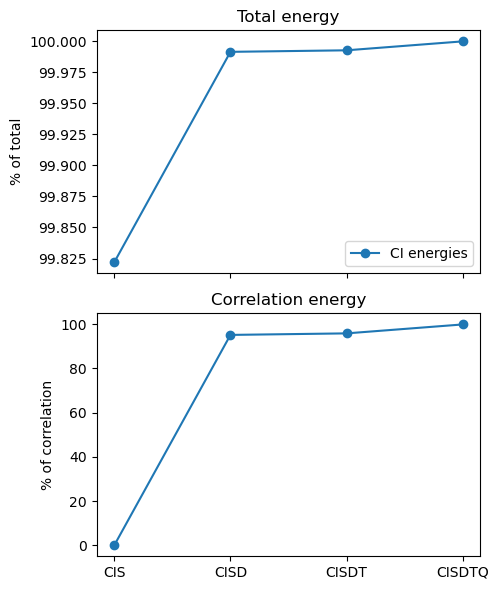

Recovered electron correlation:
  CIS   : 1.154e-10
  CISD  : 95.14
  CISDT : 95.84
  CISDTQ: 99.88


In [25]:
import matplotlib.pyplot as plt

corr_perc = (np.array(Energies)-E_hf)/(E_FCI-E_hf)*100
methods = ['CIS', 'CISD', 'CISDT', 'CISDTQ']

plt.figure(figsize=(5,6))
plt.subplot(211)
plt.plot(np.array(Energies)/E_FCI*100, 'o-',label='CI energies')
plt.title('Total energy')
plt.xticks([0, 1, 2, 3], ())
plt.ylabel("% of total")
plt.legend()

plt.subplot(212)
plt.plot(corr_perc, 'o-')
plt.title('Correlation energy')
plt.xticks([0, 1, 2, 3], methods)
plt.ylabel("% of correlation")
plt.tight_layout(); plt.show()

print('Recovered electron correlation:')
for i in range(len(methods)):
    #(Energies-E_hf)/(E_FCI-E_hf)*100:
    print(f'  {methods[i]:6}: {corr_perc[i]:.4}')

The total energy of CIS is only approximately 2% too low, but it does not recover any correlation (the optimized HF determinant does not interact with single excitations). In general, the odd excitation orders do not add much to the correlation energy. However, already with CISD, we recover more than 95% of the correlation energy, and that number rises to nearly 99.9% with CISDTQ. This is remarkable as water has 10 electrons, and thus up to 10 excitations are included in the full CI. Looking at the determinant count, CISD has only 1,141 determinants, compared to the 828,828 of full CI.

This clearly suggests using truncated schemes, and in particular CISD as a relatively efficient way to recover most of the correlation energy.

(sec:size-consistency)=
### Size consistency

The main issue with those truncated CI methods is that as the system grows larger, the importance of higher excitations increases, and thus truncated CI captures a smaller and smaller fraction of the correlation. 

This is very well illustrated when taking two identical molecules at large distance. One would normally expect the energy of this non-interacting dimer to be exactly twice that of the monomer. Let's verify it on our water molecule:

In [26]:
# Two water molecules at 100 Å distance
h2o_xyz = """6
water                                                                                                                          
O    0.000000000000        0.000000000000        0.000000000000                         
H    0.000000000000        0.740848095288        0.582094932012                         
H    0.000000000000       -0.740848095288        0.582094932012
O  100.000000000000        0.000000000000        0.000000000000                         
H  100.000000000000        0.740848095288        0.582094932012                         
H  100.000000000000       -0.740848095288        0.582094932012
"""

molecule = vlx.Molecule.from_xyz_string(h2o_xyz)
basis = vlx.MolecularBasis.read(molecule, "6-31G")

scf_drv = vlx.ScfRestrictedDriver()
scf_results = scf_drv.compute(molecule, basis)

space = mtp.OrbSpace(molecule, scf_drv.mol_orbs)
space.cisd()
ci_results = CIdrv.compute(molecule, basis, space)

E_2h2o = CIdrv.get_energy()

* Info * Reading basis set from file: /opt/anaconda3/envs/echem/lib/python3.11/site-packages/veloxchem/basis/6-31G        
                                                                                                                          
                                              Molecular Basis (Atomic Basis)                                              
                                                                                                                          
                               Basis: 6-31G                                                                               
                                                                                                                          
                               Atom Contracted GTOs           Primitive GTOs                                              
                                                                                                                          
                

                          Configuration Interaction Driver
                                                                                                                          

          Active space definition:
          ------------------------
Number of inactive (occupied) orbitals: 0
Number of active orbitals:              26
Number of virtual orbitals:             0

    This is a GASSCF wavefunction

         Cumulated   Min cumulated    Max cumulated 
 Space    orbitals      occupation       occupation
     1          10              18               20
     2          26              20               20


          CI expansion:
          -------------
Number of determinants:      18441


        ╭────────────────────────────────────╮
        │          Driver settings           │
        ╰────────────────────────────────────╯
          Max. iterations         : 40
          Initial diagonalization : 200
          Max subspace size       : 10
          Convergence thresho

In [27]:
print('    CISD energy')
print('-------------------')
print(f'Dimer:      {E_2h2o:9.5f}')
print(f'2 monomers: {2 * Energies[1]:9.5f}')
print(f'Size-consistency error: {E_2h2o - 2 * Energies[1]:5.5f}')

    CISD energy
-------------------
Dimer:      -152.21519
2 monomers: -152.22436
Size-consistency error: 0.00916


The calculation for the dimer found the energy to be higher than twice the monomer, and not equal as one would expect. This systematic failure of truncated CI is called the size-consistency error.

To understand this, let us consider a molecule $A$ whose CI expansion consists of only two Slater determinants --- the HF reference and a SD generated by exciting 2 electrons from orbitals $i, j$ to $a, b$:

$$
| \Psi_A \rangle = c_{0} | ... ij ...\rangle + c_{ijab} | ... ab ...\rangle
$$

Now add second molecule $B$ with two SDs, a HF reference and one being generated from a $klcd$ excitation:

$$
| \Psi_B \rangle = c'_{0} | ... kl ...\rangle + c'_{klcd} | ... cd ...\rangle
$$

In a correct calculation, as the two systems are far apart, the combined wave function can be expressed as a product of their individual ones:

$$
| \Psi_{AB} \rangle &= | \Psi_A \Psi_B \rangle \\
                    &= \Big( c_{0} | ... ij ...\rangle + c_{ijab} | ... ab ...\rangle \Big) \Big(c'_{0} | ... kl ...\rangle + c'_{klcd} | ... cd ...\rangle \Big) \\
                    &= c_0 c'_0 | ... ij...kl ...\rangle + c_{0}c'_{klcd} | ... ij...cd ...\rangle \\ & \qquad + c_{ijab}c'_{0} | ... ab...kl ...\rangle + c_{ijab}c'_{klcd} | ... ab...cd ...\rangle   \\
$$

The last term corresponds to a quadruple excitation from the HF reference. Since these quadruple excitations are excluded from CISD, it is clear the method cannot describe the combined system as well as it can describe the individual subsystems.

Some approximations exist to partially correct for this error. One of the simplest is the Davidson correction, in which the contributions from the quadruply excited determinants are estimated using a reasoning based on perturbation theory:

$$
\Delta E_\mathrm{Davidson} = (1 - c_0^2)(E_{\rm CISD} - E_{\rm HF}), 
$$


In [28]:
# Weight of the HF determinant for the dimer
print(CIdrv.vecs[0])

Determinant                  coef.    weight 
22222222220000000000000000  -0.965    0.932 



In [29]:
# Recompute 1 water molecule
space = mtp.OrbSpace(H2O,H2O_orbs)
space.cisd()
ci_results = CIdrv.compute(H2O,basis,space)

                          Configuration Interaction Driver
                                                                                                                          

          Active space definition:
          ------------------------
Number of inactive (occupied) orbitals: 0
Number of active orbitals:              13
Number of virtual orbitals:             0

    This is a GASSCF wavefunction

         Cumulated   Min cumulated    Max cumulated 
 Space    orbitals      occupation       occupation
     1           5               8               10
     2          13              10               10


          CI expansion:
          -------------
Number of determinants:      1141


        ╭────────────────────────────────────╮
        │          Driver settings           │
        ╰────────────────────────────────────╯
          Max. iterations         : 40
          Initial diagonalization : 200
          Max subspace size       : 10
          Convergence threshol

{'orbital_space': <multipsi.OrbSpace.OrbSpace at 0x10d46d1d0>,
 'converged': True,
 'n_iterations': 7,
 'energies': array([-76.112]),
 'ci_vectors': [<multipsi.CIVector.CIVector at 0x190daeb90>]}

In [30]:
# Weight of the HF determinant for the monomer
print(CIdrv.vecs[0])

Determinant     coef.    weight 
2222200000000  -0.981    0.962 



In [31]:
E_D_2H2O = (1-0.932)*(E_2h2o - scf_drv.get_scf_energy()) + E_2h2o
E_D_H2O = (1-0.962)*(CIdrv.get_energy() - E_hf) + CIdrv.get_energy()

print(' Davidson corrected energy')
print('---------------------------')
print(f'Dimer:      {E_D_2H2O:9.5f}')
print(f'2 monomers: {2 * E_D_H2O:9.5f}')
print(f'Size-consistency error: {E_D_2H2O - 2 * E_D_H2O:5.5f}')

 Davidson corrected energy
---------------------------
Dimer:      -152.23209
2 monomers: -152.23415
Size-consistency error: 0.00206


With this, the size-consistency error has been noticeably reduced.

Despite this, truncated CI have for the most part disappeared from the quantum chemistry landscape as more efficient and/or more accurate methods supplanted them.